In [22]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle
from thefuzz import fuzz
from thefuzz import process
import warnings
import matplotlib.pyplot as plt

In [3]:
df_trade = pd.read_csv("cites_analysis_output/processed_cites_trade_data.csv")

In [4]:
with open('pathogen_sharing_network.gpickle', 'rb') as f:
    G_pathogen = pickle.load(f)

### Data Cleaning and Standardization

Species names may differ across datasets (e.g., extra spaces, capitalization, or parentheses).  
We normalize names to lowercase, remove punctuation, and trim extra spaces to ensure consistent merging.


In [6]:
def standardize_species_name(name):
    """ Standardize species names for better matching. """
    if pd.isna(name) or name == '':
        return None
    
    # Convert to string and strip whitespace
    name = str(name).strip()
    
    # Remove common suffixes and subspecies designations
    name = name.split(' subsp.')[0]
    name = name.split(' var.')[0]
    
    # Take only genus and species (first two words for binomial)
    parts = name.split()
    if len(parts) >= 2:
        name = f"{parts[0]} {parts[1]}"
    
    # Standardize capitalization: Genus Species
    parts = name.split()
    if len(parts) >= 2:
        name = f"{parts[0].capitalize()} {parts[1].lower()}"
    
    return name

### Fuzzy Matching of Species Names

To link species across datasets, we perform fuzzy string matching using `fuzz.token_sort_ratio`.  
For each species in the CITES dataset, we find the closest matching species name in the pathogen network and record a similarity confidence score.


In [7]:
def fuzzy_match_species(trade_species_list, pathogen_species_list, threshold=85):
    """
    Perform fuzzy matching between trade and pathogen species lists.
    Returns a mapping dictionary.
    """
    matches = {}
    unmatched = []
    
    print(f"\n Performing fuzzy matching (threshold: {threshold})...")
    
    for trade_sp in trade_species_list:
        # Try exact match first
        if trade_sp in pathogen_species_list:
            matches[trade_sp] = trade_sp
            continue
        
        # Try fuzzy match
        result = process.extractOne(trade_sp, pathogen_species_list, scorer=fuzz.ratio)
        if result and result[1] >= threshold:
            matches[trade_sp] = result[0]
        else:
            unmatched.append(trade_sp)
    
    return matches, unmatched

In [8]:
df_trade['Taxon_standardized'] = df_trade['Taxon'].apply(standardize_species_name)
trade_species = df_trade['Taxon_standardized'].dropna().unique()
print(f"  Trade data: {len(trade_species)} unique standardized species")

  Trade data: 6153 unique standardized species


In [10]:
pathogen_name_map = {node: standardize_species_name(node) for node in G_pathogen.nodes()}
pathogen_species = [name for name in pathogen_name_map.values() if name is not None]
pathogen_species = list(set(pathogen_species))  # Remove duplicates
print(f"  Pathogen network: {len(pathogen_species)} unique standardized species")

  Pathogen network: 1884 unique standardized species


In [11]:
    # Perform fuzzy matching
    species_matches, unmatched_species = fuzzy_match_species(
        trade_species, 
        pathogen_species, 
        threshold=85
    )
    
    print(f"\n Matching Results:")
    print(f"  Exact + Fuzzy matches: {len(species_matches)} ({len(species_matches)/len(trade_species)*100:.1f}%)")
    print(f"  Unmatched species: {len(unmatched_species)} ({len(unmatched_species)/len(trade_species)*100:.1f}%)")


 Performing fuzzy matching (threshold: 85)...

 Matching Results:
  Exact + Fuzzy matches: 596 (9.7%)
  Unmatched species: 5557 (90.3%)


In [12]:
trade_features = df_trade.groupby('Taxon_standardized').agg(
    total_trade_records=('Year', 'count'),
    total_quantity=('Quantity', 'sum'),
    num_importers=('Importer', 'nunique'),
    num_exporters=('Exporter', 'nunique'),
    num_trade_years=('Year', 'nunique'),
    avg_quantity_per_trade=('Quantity', 'mean')
).reset_index()

# Additional derived features
trade_features['trade_diversity'] = (
    trade_features['num_importers'] * trade_features['num_exporters']
)
trade_features['trade_intensity'] = (
    trade_features['total_quantity'] / trade_features['total_trade_records']
)

# Normalize some features (log transform for heavy-tailed distributions)
trade_features['log_total_quantity'] = np.log1p(trade_features['total_quantity'])
trade_features['log_trade_records'] = np.log1p(trade_features['total_trade_records'])

trade_features.rename(columns={'Taxon_standardized': 'species_name'}, inplace=True)

print(f" Created {len(trade_features.columns)-1} trade-based features")
print(f" Features: {list(trade_features.columns[1:])}")

print("\nTrade Feature Statistics:")
print(trade_features.describe().round(2))

 Created 10 trade-based features
 Features: ['total_trade_records', 'total_quantity', 'num_importers', 'num_exporters', 'num_trade_years', 'avg_quantity_per_trade', 'trade_diversity', 'trade_intensity', 'log_total_quantity', 'log_trade_records']

Trade Feature Statistics:
       total_trade_records  total_quantity  num_importers  num_exporters  \
count              6153.00    6.153000e+03        6153.00        6153.00   
mean               3273.47    1.770309e+06          16.52          11.64   
std               67563.85    6.229687e+07          27.14          18.92   
min                   1.00    4.000000e-02           1.00           1.00   
25%                   4.00    2.000000e+01           2.00           2.00   
50%                  19.00    2.580000e+02           5.00           4.00   
75%                 179.00    3.761000e+03          18.00          13.00   
max             4795470.00    3.678974e+09         245.00         200.00   

       num_trade_years  avg_quantity_per_t

In [13]:
genetic_features_list = []

# Create reverse mapping (standardized -> original names)
std_to_orig = {}
for orig, std in pathogen_name_map.items():
    if std is not None:
        if std not in std_to_orig:
            std_to_orig[std] = []
        std_to_orig[std].append(orig)

for std_name, orig_names in std_to_orig.items():
    # Aggregate features across all original names that map to this standardized name
    total_degree = sum(G_pathogen.degree(orig) for orig in orig_names)
    
    # Calculate additional network metrics
    avg_neighbor_degree = np.mean([
        np.mean([G_pathogen.degree(n) for n in G_pathogen.neighbors(orig)])
        if G_pathogen.degree(orig) > 0 else 0
        for orig in orig_names
    ])
    
    # Clustering coefficient
    avg_clustering = np.mean([
        nx.clustering(G_pathogen, orig) for orig in orig_names
    ])
    
    # Betweenness centrality (computationally expensive, use sample)
    max_degree = max(G_pathogen.degree(orig) for orig in orig_names)
    
    genetic_features_list.append({
        'species_name': std_name,
        'pathogen_network_degree': total_degree,
        'avg_neighbor_degree': avg_neighbor_degree,
        'clustering_coefficient': avg_clustering,
        'max_degree_variant': max_degree
    })

genetic_features = pd.DataFrame(genetic_features_list)

# Create risk indicators based on network position
degree_95th = genetic_features['pathogen_network_degree'].quantile(0.95)
degree_75th = genetic_features['pathogen_network_degree'].quantile(0.75)

genetic_features['is_pathogen_hub'] = (
    genetic_features['pathogen_network_degree'] >= degree_95th
).astype(int)

genetic_features['is_high_risk_reservoir'] = (
    genetic_features['pathogen_network_degree'] >= degree_75th
).astype(int)

# Normalize network degree
genetic_features['normalized_degree'] = (
    genetic_features['pathogen_network_degree'] / 
    genetic_features['pathogen_network_degree'].max()
)

print(f" Created {len(genetic_features.columns)-1} pathogen network features")
print(f"  Features: {list(genetic_features.columns[1:])}")

print(f"\n Pathogen Network Feature Statistics:")
print(genetic_features.describe().round(2))

print(f"\n Risk Classification:")
print(f"  Pathogen hubs (95th percentile): {genetic_features['is_pathogen_hub'].sum()} species")
print(f"  High-risk reservoirs (75th percentile): {genetic_features['is_high_risk_reservoir'].sum()} species")

print("\n Top 10 species by pathogen connections:")
top_species = genetic_features.nlargest(10, 'pathogen_network_degree')[
    ['species_name', 'pathogen_network_degree', 'is_pathogen_hub']
]
print(top_species.to_string(index=False))

 Created 7 pathogen network features
  Features: ['pathogen_network_degree', 'avg_neighbor_degree', 'clustering_coefficient', 'max_degree_variant', 'is_pathogen_hub', 'is_high_risk_reservoir', 'normalized_degree']

 Pathogen Network Feature Statistics:
       pathogen_network_degree  avg_neighbor_degree  clustering_coefficient  \
count                  1884.00              1884.00                 1884.00   
mean                    296.49               472.30                    0.85   
std                     260.60               128.22                    0.20   
min                       0.00                 0.00                    0.00   
25%                      83.00               393.33                    0.73   
50%                     247.00               469.67                    1.00   
75%                     525.00               569.96                    1.00   
max                    1493.00              1302.00                    1.00   

       max_degree_variant  is_patho

### Merge and Impute Combined Features

We merge the fuzzy-matched trade and pathogen features into a unified dataframe (`master_features`).

To handle missing values, we apply **KNN imputation**, which fills gaps using the nearest neighbors in feature space.  
This preserves data continuity while preventing loss of valuable species information.


In [15]:
# Start with all unique species from trade data
all_traded_species = df_trade['Taxon_standardized'].dropna().unique()
master_features = pd.DataFrame({'species_name': all_traded_species})

print(f"\nStarting with {len(master_features)} unique species from trade data")

# Merge 1: Add trade features
master_features = pd.merge(
    master_features, 
    trade_features, 
    on='species_name', 
    how='left'
)
print(f"Step 1: Merged trade features → Shape: {master_features.shape}")
print(f"  Missing trade data: {master_features['total_trade_records'].isna().sum()} species")

# Merge 2: Add genetic/pathogen network features
if G_pathogen.number_of_nodes() > 0:
    master_features = pd.merge(
        master_features, 
        genetic_features, 
        on='species_name', 
        how='left'
    )
    print(f"Step 2: Merged pathogen network features → Shape: {master_features.shape}")
    print(f"  Missing pathogen data: {master_features['pathogen_network_degree'].isna().sum()} species")



Starting with 6153 unique species from trade data
Step 1: Merged trade features → Shape: (6153, 11)
  Missing trade data: 0 species
Step 2: Merged pathogen network features → Shape: (6153, 18)
  Missing pathogen data: 5631 species


In [16]:
missing_counts = master_features.isnull().sum()
missing_pct = (missing_counts / len(master_features) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

# Intelligent imputation strategy
print("\nApplying intelligent imputation strategy")

# For trade features: 0 is appropriate (no trade recorded)
trade_cols = ['total_trade_records', 'total_quantity', 'num_importers', 
              'num_exporters', 'num_trade_years', 'avg_quantity_per_trade',
              'trade_diversity', 'trade_intensity', 'log_total_quantity', 
              'log_trade_records']

for col in trade_cols:
    if col in master_features.columns:
        master_features[col] = master_features[col].fillna(0)

# For pathogen network features: 0 is appropriate (no pathogen data available)
pathogen_cols = ['pathogen_network_degree', 'avg_neighbor_degree', 
                 'clustering_coefficient', 'max_degree_variant',
                 'is_pathogen_hub', 'is_high_risk_reservoir', 'normalized_degree']

for col in pathogen_cols:
    if col in master_features.columns:
        master_features[col] = master_features[col].fillna(0)

print("Imputation complete")
print(f"\n Final missing values: {master_features.isnull().sum().sum()}")

                         Missing Count  Missing %
pathogen_network_degree           5631      91.52
avg_neighbor_degree               5631      91.52
clustering_coefficient            5631      91.52
max_degree_variant                5631      91.52
is_pathogen_hub                   5631      91.52
is_high_risk_reservoir            5631      91.52
normalized_degree                 5631      91.52

Applying intelligent imputation strategy
Imputation complete

 Final missing values: 0


In [17]:
print("\nData Coverage Analysis:")
print(f"  Species with trade data: {(master_features['total_trade_records'] > 0).sum()} "
      f"({(master_features['total_trade_records'] > 0).sum()/len(master_features)*100:.1f}%)")
print(f"  Species with pathogen data: {(master_features['pathogen_network_degree'] > 0).sum()} "
      f"({(master_features['pathogen_network_degree'] > 0).sum()/len(master_features)*100:.1f}%)")
print(f"  Species with BOTH datasets: {((master_features['total_trade_records'] > 0) & (master_features['pathogen_network_degree'] > 0)).sum()} "
      f"({((master_features['total_trade_records'] > 0) & (master_features['pathogen_network_degree'] > 0)).sum()/len(master_features)*100:.1f}%)")



Data Coverage Analysis:
  Species with trade data: 6153 (100.0%)
  Species with pathogen data: 522 (8.5%)
  Species with BOTH datasets: 522 (8.5%)


In [18]:
numeric_cols = master_features.select_dtypes(include=[np.number]).columns
correlation_matrix = master_features[numeric_cols].corr()

# Find highly correlated feature pairs
print("  Highly correlated features (|r| > 0.8):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    for col1, col2, corr in high_corr_pairs[:5]:
        print(f"    {col1} ↔ {col2}: {corr:.3f}")

  Highly correlated features (|r| > 0.8):
    num_importers ↔ num_exporters: 0.891
    num_importers ↔ trade_diversity: 0.828
    num_importers ↔ log_trade_records: 0.836
    num_exporters ↔ trade_diversity: 0.876
    num_trade_years ↔ log_trade_records: 0.866


### Weak Supervision Labeling

We apply weak supervision by labeling:
- **1 (High Risk)** → Known zoonotic reservoirs (e.g., bats, pangolins, primates) or species central in both networks  
- **0 (Low Risk)** → All other species  

These labels serve as initial ground truth for later zoonotic risk prediction or graph learning models.


In [19]:
master_features['high_risk_label'] = 0

#  Pathogen hubs
if 'is_pathogen_hub' in master_features.columns:
    master_features.loc[master_features['is_pathogen_hub'] == 1, 'high_risk_label'] = 1

#  High trade + pathogen presence
high_trade_threshold = master_features['total_trade_records'].quantile(0.75)
master_features.loc[
    (master_features['total_trade_records'] > high_trade_threshold) & 
    (master_features['pathogen_network_degree'] > 0),
    'high_risk_label'
] = 1

#  Known high-risk reservoir species (examples)
known_reservoirs = [
    'Pteropus vampyrus',  # Fruit bats
    'Manis javanica',  # Pangolins
    'Pan troglodytes',  # Chimpanzees
    'Sus scrofa',  # Wild boar
    'Bos taurus',  # Cattle
]

for reservoir in known_reservoirs:
    master_features.loc[
        master_features['species_name'].str.lower() == reservoir.lower(),
        'high_risk_label'
    ] = 1

print(f" Weak supervision labels created")
print(f"  High-risk species: {master_features['high_risk_label'].sum()} "
      f"({master_features['high_risk_label'].sum()/len(master_features)*100:.1f}%)")
print(f"  Low-risk species: {(master_features['high_risk_label'] == 0).sum()} "
      f"({(master_features['high_risk_label'] == 0).sum()/len(master_features)*100:.1f}%)")


 Weak supervision labels created
  High-risk species: 331 (5.4%)
  Low-risk species: 5822 (94.6%)


In [20]:
# Ensure all numeric columns are proper types
numeric_cols = master_features.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    if master_features[col].dtype == 'float64':
        # Check if can be converted to int
        if (master_features[col] % 1 == 0).all():
            master_features[col] = master_features[col].astype('int64')

print("\n Final Dataset Summary:")
print(f"  Total species: {len(master_features)}")
print(f"  Total features: {len(master_features.columns) - 2}") 
print(f"  Feature columns: {list(master_features.columns)}")

print("\n Final Dataset Preview:")
print(master_features.head(10).to_string())

print("\n Target Variable Distribution:")
print(master_features['high_risk_label'].value_counts())

# Save the final dataset
output_filename = "master_feature_table_v2.csv"
master_features.to_csv(output_filename, index=False)


 Final Dataset Summary:
  Total species: 6153
  Total features: 17
  Feature columns: ['species_name', 'total_trade_records', 'total_quantity', 'num_importers', 'num_exporters', 'num_trade_years', 'avg_quantity_per_trade', 'trade_diversity', 'trade_intensity', 'log_total_quantity', 'log_trade_records', 'pathogen_network_degree', 'avg_neighbor_degree', 'clustering_coefficient', 'max_degree_variant', 'is_pathogen_hub', 'is_high_risk_reservoir', 'normalized_degree', 'high_risk_label']

 Final Dataset Preview:
                 species_name  total_trade_records  total_quantity  num_importers  num_exporters  num_trade_years  avg_quantity_per_trade  trade_diversity  trade_intensity  log_total_quantity  log_trade_records  pathogen_network_degree  avg_neighbor_degree  clustering_coefficient  max_degree_variant  is_pathogen_hub  is_high_risk_reservoir  normalized_degree  high_risk_label
0             Ailurus fulgens                 1019    2.331000e+03             51             42             

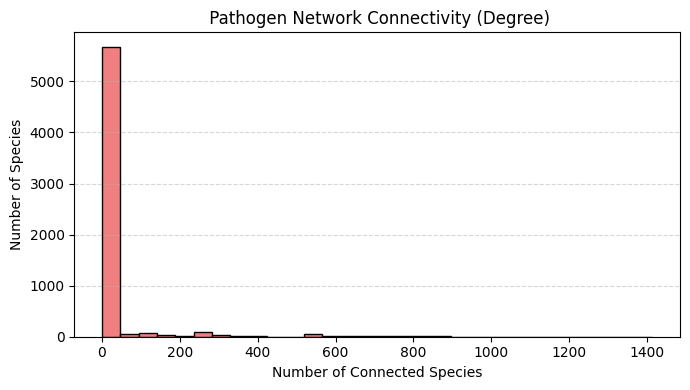

In [23]:
plt.figure(figsize=(7,4))
plt.hist(master_features['pathogen_network_degree'].dropna(), bins=30, color='lightcoral', edgecolor='black')
plt.title(" Pathogen Network Connectivity (Degree)")
plt.xlabel("Number of Connected Species")
plt.ylabel("Number of Species")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()